CLASIFICACIÓN CANCER DE MAMA CON EL MODELO PRE-ENTRENADO    VGG16
CAMBIO DE ESTRUCTURA

In [1]:
import tensorflow as tf
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
import warnings 
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import imblearn
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')                    # Turn the warnings off.
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive/Datos')

In [4]:
BC_df_copy = pd.read_csv('/content/drive/MyDrive/Datos/Breat_cancer_data.csv')
BC_df_copy.head()

,Unnamed: 0,patient_ID,pathes,diagnosis
0,0,10256,/content/drive/MyDrive/Datos/cancer2/10256/0/1...,0
1,1,10256,/content/drive/MyDrive/Datos/cancer2/10256/0/1...,0
2,2,10256,/content/drive/MyDrive/Datos/cancer2/10256/0/1...,0
3,3,10256,/content/drive/MyDrive/Datos/cancer2/10256/0/1...,0
4,4,10256,/content/drive/MyDrive/Datos/cancer2/10256/0/1...,0


In [5]:
BC_df_copy = BC_df_copy.sort_values('patient_ID')

In [6]:
BC_df_copy.iloc[1400:1401,:]

,Unnamed: 0,patient_ID,pathes,diagnosis
2046,2046,10255,/content/drive/MyDrive/Datos/cancer2/10255/0/1...,0


In [7]:
from PIL.Image import open
BC_df_copy['pixels'] =  BC_df_copy['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))

**CREACIÓN DE LOS CONJUNTOS DE DATOS**

In [8]:
X = BC_df_copy['pixels']
y = np.array(BC_df_copy['diagnosis'])

In [9]:
X_train = X[0:1400]
X_validation = X[1400:1674]
X_test = X[1674:2144]
y_train =y[0:1400]
y_validation = y[1400:1674]
y_test = y[1674:2144]
print('La dimension de X_train :'+" "+str(X_train.shape))
print('La dimension de X_validation :'+" "+str(X_validation.shape))
print('La dimension de X_test :'+" "+str(X_test.shape))

La dimension de X_train : (1400,)
La dimension de X_validation : (274,)
La dimension de X_test : (470,)


In [10]:
#información relevante
num_train = len((X_train))
num_validation = len((X_validation))
num_test = len((X_test))
num_classes = 1
#num_iterations = int(num_train/batch_size)

# Print important info
print(f'Numero de imágenes para train: {num_train} \
        \nNumero de imágenes para validation: {num_validation} \
        \nNumero de imágenes para test: {num_test} \
        \nNumero de clases: {num_classes} ')

Numero de imágenes para train: 1400         
Numero de imágenes para validation: 274         
Numero de imágenes para test: 470         
Numero de clases: 1 


In [11]:
# training set
img_list = []
for i in range (0,len(X_train)):
    brain_img =np.array(X_train)[i]
    img_arr = img_to_array(brain_img/255).astype(np.float32)
    img_list.append(img_arr)
X_scaled = np.array(img_list)

print(X_scaled.shape)

(1400, 224, 224, 3)


In [12]:
# validation set
img_validation = []
for i in range (0,len(X_validation)):
    brain_img_validation =np.array(X_validation)[i]
    img_validation_arr = img_to_array(brain_img_validation/255).astype(np.float32)
    img_validation.append((img_validation_arr))
X_scaled_validation = np.array(img_validation)

print(X_scaled_validation.shape)

(274, 224, 224, 3)


In [13]:
# test set
img_test = []
for i in range (0,len(X_test)):
    brain_img_test =np.array(X_test)[i]
    img_test_arr = img_to_array(brain_img_test/255).astype(np.float32)
    img_test.append((img_test_arr))
X_scaled_test = np.array(img_test)

print(X_scaled_test.shape)

(470, 224, 224, 3)


****Balanceo de datos para el train set****

In [14]:
X_train_shape = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten = X_scaled.reshape(X_scaled.shape[0],X_train_shape)

In [15]:
ros = RandomOverSampler(random_state=10)
X_train_res, y_train = ros.fit_resample(X_Flatten, y_train)

In [16]:
row,col,channel = 224 ,224 , 3 
X_scaled = X_train_res.reshape(len(X_train_res),row,col,channel)
# chec the shape of our training set
print('The shape of the training set after reshape it :'+" "+str(X_scaled.shape))

The shape of the training set after reshape it : (2508, 224, 224, 3)


one-hot-encoding

In [17]:
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(2508, 2)
(274, 2)
(470, 2)


**CREACIÓN y ENTRENAMIENTO DEL MODELO**

In [18]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling1D

In [19]:
n_epochs = 20
#batch_size=32
batch_size_min= 32
batch_size_max= 64
learn_rate = 0.0002
validation_processed = (X_scaled_validation,y_validation)

In [20]:
drop_prob = 0.7
my_model = Sequential()
# 1st convolution + pooling.
my_model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(5,5),padding='same',activation="relu"))        # 3 channels of color.
my_model.add(MaxPooling2D(pool_size=2))
# 2nd convolution + pooling.
my_model.add(Conv2D(filters=64,kernel_size=(5,5), padding='same',activation="relu"))
my_model.add(MaxPooling2D(pool_size=2))
# Flattened fully connected layer.
my_model.add(Flatten())
my_model.add(Dense(units = 1024, activation="relu"))
# Apply dropout.
my_model.add(Dropout(rate=drop_prob))
# Output layer.
my_model.add(Dense(units = 2, activation="softmax"))

In [21]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [ ]:
#num_iterations = int(num_train/batch_size)

In [22]:
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

In [23]:
mejorAccuracy=0.000
mejorBatch =0
for i in range (batch_size_min, batch_size_max, 8):
  my_summary= my_model.fit(X_scaled, y_train, epochs=n_epochs, batch_size=i, validation_data=validation_processed, verbose=1)
  CC= my_model.evaluate(X_scaled_test, y_test, verbose=0)[1]
  if np.round(CC,3) > mejorAccuracy:
    mejorAccuracy =np.round(CC,3)
    mejorBatch=i
print(mejorAccuracy)
print(mejorBatch)

Epoch 1/20
79/79 [==============================] - 26s 207ms/step - loss: 0.9240 - accuracy: 0.7815 - val_loss: 0.3986 - val_accuracy: 0.8431
Epoch 2/20
79/79 [==============================] - 15s 190ms/step - loss: 0.2573 - accuracy: 0.9083 - val_loss: 0.3801 - val_accuracy: 0.8394
Epoch 3/20
79/79 [==============================] - 15s 194ms/step - loss: 0.1533 - accuracy: 0.9510 - val_loss: 0.4990 - val_accuracy: 0.7810
Epoch 4/20
79/79 [==============================] - 15s 194ms/step - loss: 0.0960 - accuracy: 0.9717 - val_loss: 0.5221 - val_accuracy: 0.8029
Epoch 5/20
79/79 [==============================] - 15s 192ms/step - loss: 0.0714 - accuracy: 0.9805 - val_loss: 0.7697 - val_accuracy: 0.7920
Epoch 6/20
79/79 [==============================] - 15s 192ms/step - loss: 0.0351 - accuracy: 0.9904 - val_loss: 0.8467 - val_accuracy: 0.7956
Epoch 7/20
79/79 [==============================] - 15s 192ms/step - loss: 0.0238 - accuracy: 0.9940 - val_loss: 0.8145 - val_accuracy: 0.7993

In [ ]:

#my_summary = my_model.fit(X_scaled,y_train, epochs=n_epochs, batch_size = batch_size, validation_data=validation_processed, verbose = 1)

Epoch 1/20
79/79 [==============================] - 26s 207ms/step - loss: 1.3588 - accuracy: 0.7476 - val_loss: 0.4089 - val_accuracy: 0.8248
Epoch 2/20
79/79 [==============================] - 15s 191ms/step - loss: 0.2548 - accuracy: 0.9047 - val_loss: 0.4572 - val_accuracy: 0.8102
Epoch 3/20
79/79 [==============================] - 15s 190ms/step - loss: 0.1294 - accuracy: 0.9593 - val_loss: 0.7297 - val_accuracy: 0.7591
Epoch 4/20
79/79 [==============================] - 15s 191ms/step - loss: 0.0792 - accuracy: 0.9785 - val_loss: 0.4923 - val_accuracy: 0.8175
Epoch 5/20
79/79 [==============================] - 15s 191ms/step - loss: 0.0477 - accuracy: 0.9888 - val_loss: 0.9533 - val_accuracy: 0.7920
Epoch 6/20
79/79 [==============================] - 15s 191ms/step - loss: 0.0216 - accuracy: 0.9956 - val_loss: 0.9694 - val_accuracy: 0.7956
Epoch 7/20
79/79 [==============================] - 15s 192ms/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 1.2582 - val_accuracy: 0.7701

In [ ]:
my_summary.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**GRÁFICAS. Evaluación de los resultados con el conjunto de validación**

In [ ]:
accuracy_validation = my_summary.history['val_accuracy'][-1]
accuracy_validation

0.7956204414367676

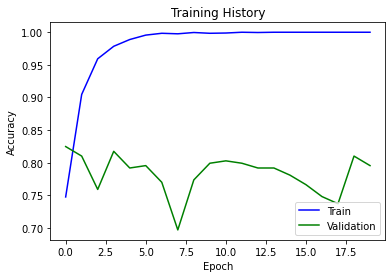

In [ ]:
# Gráfica para visualizar el resultado del entrenamiento del modelo. 
n_skip = 0                 # Skip the first few steps.
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**MÉTRICAS. Evaluación de los resultados con el conjunto de test**

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix, multilabel_confusion_matrix

In [ ]:
eval_score = my_model.evaluate(X_scaled_test,y_test)
print('loss en la evaluacion :'+' '+str(eval_score[0]*100))
print('accuracy en la evaluacion :'+' '+str(eval_score[1]*100))

15/15 [==============================] - 1s 93ms/step - loss: 0.5154 - accuracy: 0.9255
loss en la evaluacion : 51.54308080673218
accuracy en la evaluacion : 92.55319237709045


In [ ]:
y_pred = my_model.predict(X_scaled_test)
y_pred = np.round(y_pred).astype(int)

In [ ]:
target_name = ['benigno','maligno']
classification_report(y_true=y_test , y_pred=y_pred , output_dict=True , target_names= target_name )

{'benigno': {'f1-score': 0.9525101763907734,
  'precision': 0.9140625,
  'recall': 0.9943342776203966,
  'support': 353},
 'macro avg': {'f1-score': 0.8900481916436624,
  'precision': 0.9454033430232558,
  'recall': 0.8561414977845573,
  'support': 470},
 'maligno': {'f1-score': 0.8275862068965516,
  'precision': 0.9767441860465116,
  'recall': 0.717948717948718,
  'support': 117},
 'micro avg': {'f1-score': 0.925531914893617,
  'precision': 0.925531914893617,
  'recall': 0.925531914893617,
  'support': 470},
 'samples avg': {'f1-score': 0.925531914893617,
  'precision': 0.925531914893617,
  'recall': 0.925531914893617,
  'support': 470},
 'weighted avg': {'f1-score': 0.9214120818571054,
  'precision': 0.9296662388668976,
  'recall': 0.925531914893617,
  'support': 470}}

**matriz de confusión**

In [ ]:
multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[[ 84,  33],
        [  2, 351]],

       [[351,   2],
        [ 33,  84]]])